In [1]:
# Fetch and import APX wrapper class
# !curl https://raw.githubusercontent.com/rasmus-pagh/apx/main/apx.py -o apx.py
import apx
from importlib import reload
reload(apx)
from apx import DataFile, LinearProgram, np
import networkx as nx
from itertools import combinations

# Approximating vertex cover

In [10]:
def load_graph(filename):
  graph = nx.Graph(name=filename)
  for e in DataFile(filename):
    graph.add_edge(*e)
  return graph


def round_solution(solution):
    rounded_value, rounded_solution = 0, {}
    for x, v in solution.items():
        r = int(np.round(v + 1e-10))
        # Add small constant to deal with numerical issues for numbers close to 1/2
        rounded_solution[x] = r
        rounded_value += r
    return rounded_value, rounded_solution


def vertex_cover_lp(graph, triangle_constraints=False):
  lp = LinearProgram('min')
  buckets = {}
  objective = {}
  
  # Create objective and initialize buckets
  for v in graph.nodes():
    objective[v] = 1.0
    buckets[v] = []
  
  # Add edge constraints and fill buckets
  for (u,v) in graph.edges():
    lp.add_constraint({u: 1, v: 1}, 1)
    if graph.degree[u] <= graph.degree[v]:
      buckets[u].append(v)
    else:
      buckets[v].append(u)
          
  # Add triangle constraints
  if triangle_constraints:
    for u, bucket in buckets.items():
      for (v,w) in combinations(bucket, 2):
        if graph.has_edge(v, w):
          lp.add_constraint({u: 1, v: 1, w: 1}, 2)
      
  lp.set_objective(objective)
  return lp


In [11]:
table = f"Graph & Value & Rounded value & Value & Rounded Value\\\\\n\\hline\n"

for filename in DataFile.graph_files:
  graph = load_graph(filename)
  
  lp = vertex_cover_lp(graph)
  value, solution = lp.solve()
  rounded_value, rounded_solution = round_solution(solution)
  
  lp_t = vertex_cover_lp(graph, triangle_constraints=True)
  value_t, solution_t = lp_t.solve()
  rounded_value_t, rounded_solution_t = round_solution(solution_t)
  
  print(f"======== {filename} ========")
  print("Without triangle constraints:")
  print(f"\t- Solution: {solution}")
  print(f"\t- Rounded: {rounded_solution}")
  print("With triangle constraints:")
  print(f"\t- Solution: {solution_t}")
  print(f"\t- Rounded: {rounded_solution_t}\n")
  
  table += f"\\lstinline|{filename}| & {value:.2f} & {rounded_value} & {value_t:.2f} & {rounded_value_t}\\\\\n"

print(table)

======== routes.txt ========
Without triangle constraints:
	- Solution: {'JFK': 0.5, 'MCO': 0.5, 'ATL': 0.5, 'ORD': 0.5, 'HOU': 0.5, 'DEN': 0.5, 'DFW': 0.5, 'PHX': 0.5, 'LAS': 0.5, 'LAX': 0.5}
	- Rounded: {'JFK': 1, 'MCO': 1, 'ATL': 1, 'ORD': 1, 'HOU': 1, 'DEN': 1, 'DFW': 1, 'PHX': 1, 'LAS': 1, 'LAX': 1}
With triangle constraints:
	- Solution: {'JFK': 0.0, 'MCO': 1.0, 'ATL': 1.0, 'ORD': 1.0, 'HOU': 0.0, 'DEN': -0.0, 'DFW': 1.0, 'PHX': 1.0, 'LAS': 1.0, 'LAX': 0.0}
	- Rounded: {'JFK': 0, 'MCO': 1, 'ATL': 1, 'ORD': 1, 'HOU': 0, 'DEN': 0, 'DFW': 1, 'PHX': 1, 'LAS': 1, 'LAX': 0}

======== petersen.txt ========
Without triangle constraints:
	- Solution: {'A': 0.5, 'B': 0.5, 'E': 0.5, '1': 0.5, 'C': 0.5, '2': 0.5, 'D': 0.5, '3': 0.5, '4': 0.5, '5': 0.5}
	- Rounded: {'A': 1, 'B': 1, 'E': 1, '1': 1, 'C': 1, '2': 1, 'D': 1, '3': 1, '4': 1, '5': 1}
With triangle constraints:
	- Solution: {'A': 0.5, 'B': 0.5, 'E': 0.5, '1': 0.5, 'C': 0.5, '2': 0.5, 'D': 0.5, '3': 0.5, '4': 0.5, '5': 0.5}
	- Rounde

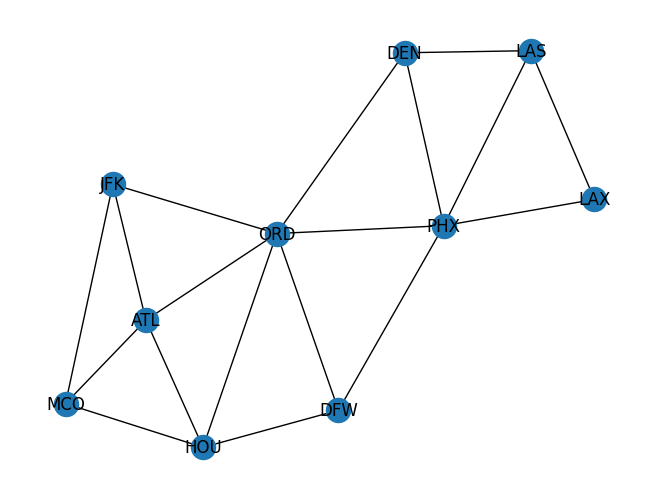

In [25]:
# Visualize routes.txt and save as routes.pdf
import matplotlib.pyplot as plt

graph = load_graph("routes.txt")
nx.draw(graph, with_labels=True)
plt.savefig("routes.pdf")